**Importing Dependencies**

In [19]:
# Imports
# Gymnasium imports
import gymnasium as gym 
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# Import helpers
import numpy as np
import pandas as pd
import random
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

from collections import deque

# Import stable baselines
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

from Environment.env_v6 import *
from Functions.visualization_functions import *

**Configuration of the Scenario**

In [20]:
# Configuration of the network
with open('./Config/network_config_v0.json') as file:
    network_config = file.read()

# TODO : Implement configuaration for cost and demand (actual and exptected)

**Building the environment**

In [21]:
EP_LENGTH = 30 # Length of the episode

env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

Node Attributes:
Node A: {'type': 'manufacturer', 'I': 30}
Node B: {'type': 'manufacturer', 'I': 28}
Node C: {'type': 'manufacturer', 'I': 32}
Node D: {'type': 'distributor'}
Node S: {'type': 'source'}


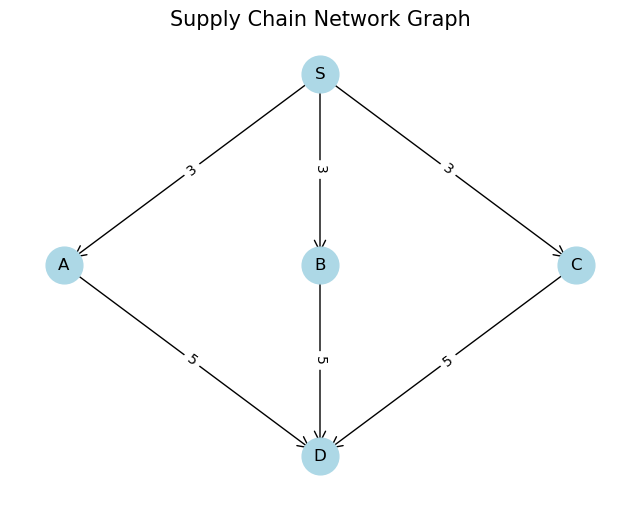

In [22]:
env.render_network()

In [23]:
env.state.shape

(93,)

In [24]:
from stable_baselines3.common.env_checker import check_env

check_env(env, warn=True)

**Testng the environment**

In [25]:
env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info, _ = env.step(action)
        score += reward

        env.render()

# 30, 28, 32

Episode Length: 1
Stock Level: [[30. 28. 32.]]
Planned Demand: [0. 0. 0.]
Actual Demand: [0. 0. 0.]
Action: [15, 50, 50]
Order: [0 0 0]
Reward: 0

Backlog:
{'A': deque([]), 'B': deque([]), 'C': deque([])}
Order Queue:
{   'A': deque([0, 0, 15], maxlen=3),
    'B': deque([0, 0, 50], maxlen=3),
    'C': deque([0, 0, 50], maxlen=3)}

Episode Length: 2
Stock Level: [[22. 28. 18.]]
Planned Demand: [12.  0. 11.]
Actual Demand: [ 8.  0. 14.]
Action: [50, 50, 0]
Order: [0 0 0]
Reward: -71.5

Backlog:
{'A': deque([]), 'B': deque([]), 'C': deque([])}
Order Queue:
{   'A': deque([0, 15, 50], maxlen=3),
    'B': deque([0, 50, 50], maxlen=3),
    'C': deque([0, 50, 0], maxlen=3)}

Episode Length: 3
Stock Level: [[15. 28. 12.]]
Planned Demand: [9. 0. 7.]
Actual Demand: [7. 0. 6.]
Action: [50, 50, 15]
Order: [0 0 0]
Reward: 386.0

Backlog:
{'A': deque([]), 'B': deque([]), 'C': deque([])}
Order Queue:
{   'A': deque([15, 50, 50], maxlen=3),
    'B': deque([50, 50, 50], maxlen=3),
    'C': deque([50, 0

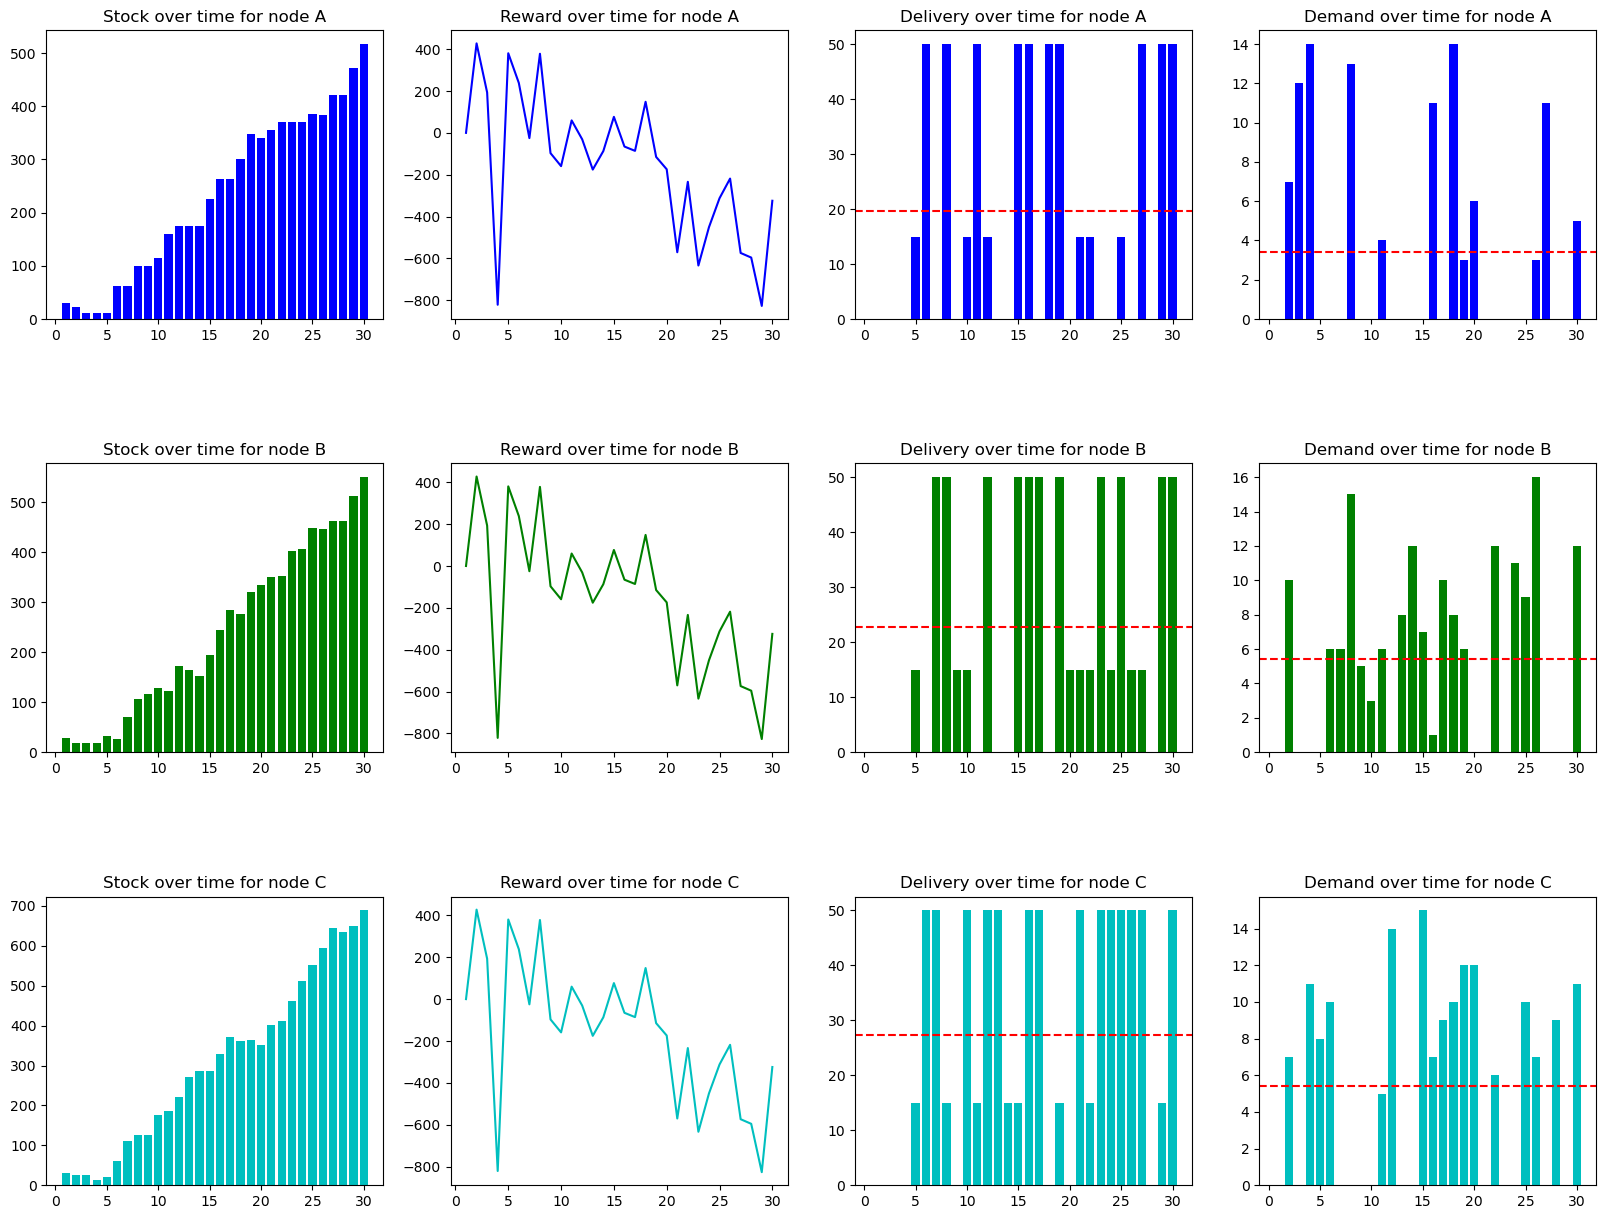

In [26]:
df = pd.read_csv('./Data/2024-11-06_20_last_environment_data.csv')
plot_data(df)

**Train Model**


In [9]:
log_path = os.path.join('Training', 'Logs')
model_path = os.path.join('Training', 'Models', 'PPO')
# model_path = os.path.join('Training', 'Models', 'A2C')

In [10]:
env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

def make_env():
    # Create a new environment here
    env = SS_Mngmt_Env(network_config=network_config, EP_LENGTH=EP_LENGTH, render_mode="human")
    return env

num_envs = 8

# dummy_env = DummyVecEnv([lambda: env])
vec_env = make_vec_env(make_env, n_envs=num_envs)

# model = PPO("MlpPolicy", 
#             dummy_env,
#             learning_rate = 0.0007, # 0.0003
#             gamma = 0.99, # 0.95
#             verbose=1,
#             tensorboard_log=log_path)

model = A2C("MlpPolicy",
            vec_env,
            learning_rate = 0.0005,
            gamma = 0.99,
            verbose=1,
            tensorboard_log=log_path)

# model = A2C(
#     "MlpPolicy",
#     vec_env,
#     learning_rate=0.0003,           # Lower learning rate for smoother updates
#     gamma=0.95,                      # Slightly lower discount factor for faster convergence on immediate rewards
#     ent_coef=0.01,                   # Add an entropy coefficient to encourage exploration
#     verbose=1,
#     tensorboard_log=log_path,
# )

Using cpu device


In [11]:
model.learn(total_timesteps=500_000)

Logging to Training/Logs/A2C_15
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 30        |
|    ep_rew_mean        | -2.03e+03 |
| time/                 |           |
|    fps                | 6532      |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 4000      |
| train/                |           |
|    entropy_loss       | -3.19     |
|    explained_variance | 0.00806   |
|    learning_rate      | 0.0005    |
|    n_updates          | 99        |
|    policy_loss        | -180      |
|    value_loss         | 1.69e+05  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 30       |
|    ep_rew_mean        | -493     |
| time/                 |          |
|    fps                | 6884     |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 

In [17]:
model.save(model_path)
model.load(model_path)

evaluate_policy(model, vec_env, n_eval_episodes=1, render=True, return_episode_rewards=True)
# evaluate_policy(model, dummy_env, n_eval_episodes=1, render=True, return_episode_rewards=True)

Episode Length: 1
Stock Level: [[30. 18. 32.]]
Planned Demand: [0. 9. 0.]
Actual Demand: [ 0. 10.  0.]
Action: [15, 15, 15]
Order: [0 0 0]
Reward: 0

Backlog:
{'A': deque([]), 'B': deque([]), 'C': deque([])}
Order Queue:
{   'A': deque([0, 0, 15], maxlen=3),
    'B': deque([0, 0, 15], maxlen=3),
    'C': deque([0, 0, 15], maxlen=3)}

Episode Length: 1
Stock Level: [[30. 28. 26.]]
Planned Demand: [0. 0. 9.]
Actual Demand: [0. 0. 6.]
Action: [15, 15, 15]
Order: [0 0 0]
Reward: 0

Backlog:
{'A': deque([]), 'B': deque([]), 'C': deque([])}
Order Queue:
{   'A': deque([0, 0, 15], maxlen=3),
    'B': deque([0, 0, 15], maxlen=3),
    'C': deque([0, 0, 15], maxlen=3)}

Episode Length: 1
Stock Level: [[25. 28. 32.]]
Planned Demand: [6. 0. 0.]
Actual Demand: [5. 0. 0.]
Action: [15, 15, 15]
Order: [0 0 0]
Reward: 0

Backlog:
{'A': deque([]), 'B': deque([]), 'C': deque([])}
Order Queue:
{   'A': deque([0, 0, 15], maxlen=3),
    'B': deque([0, 0, 15], maxlen=3),
    'C': deque([0, 0, 15], maxlen=3)}

([4144.5], [30])

In [15]:
file = './Data/2024-11-06_21_last_environment_data.csv'
df = pd.read_csv(file)

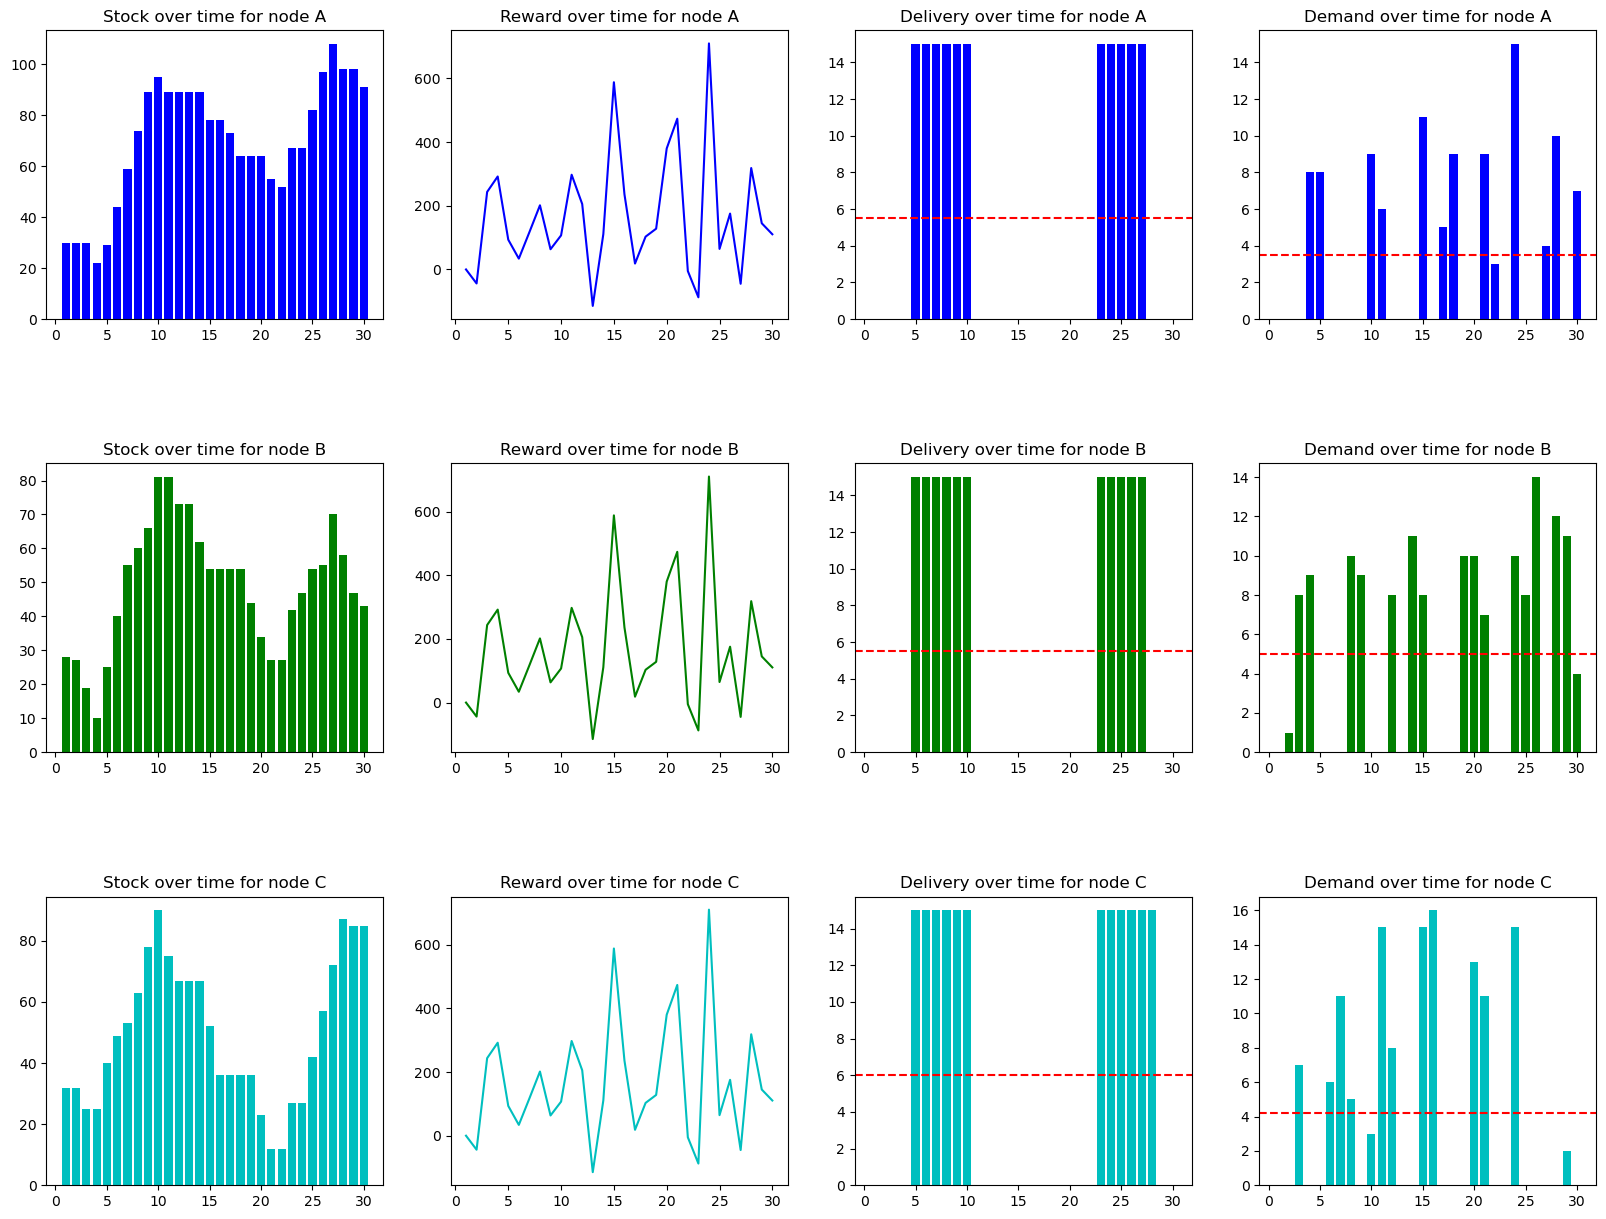

In [16]:
plot_data(df)